In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Hi everyone, this time I'm going to analyse a dataset that contains credit card transactions made by European cardholders in just 2 days in September 2013. Based on the content provided by Kaggle and the authors, the dataset presents imbalanced values between few hundred frauds out of more than two hundred thousands of transactions. The objective is to create a supervised machine learning model for the credit card companies to detect fraudulent transactions, so that customers are not charged for items that they did not purchase.

Most of the features' or variables' or columns' names were already transformed or censored due to confidentiality issues, leaving only Time, Amount, and Class.

Feature **'Time'** contains the seconds elapsed between each transaction and the first transaction in the dataset.

Feature **'Amount'** contains the transaction amount.

Feature **'Class'** is the response variable **(1=fraud and 0=not fraud)**.

## I. IMPORT LIBRARIES

#### Uncomment the lines below if required packages are not already installed.

**!pip install -U scikit-learn**

**!pip install optuna**

**!pip install --upgrade xgboost scikit-learn**

**!pip install optuna xgboost**

In [ ]:
# pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.5 MB/s eta 0:00:00


In [ ]:
# pip install --upgrade xgboost scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install optuna xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gdown
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

import optuna
from xgboost import XGBClassifier
from pprint import pprint

from sklearn.metrics import roc_curve, auc
import joblib

## II. LOAD AND CHECK THE DATASET

**In this part, I'm going to import the dataset from my Google Drive and load it into the notebook to explore the features (EDA).**

In [5]:
# Import the Credit Card Dataset from Google Drive
file_id = '1QhFp1EMfM2FHHqZfhG2gErnAYYGroS_X'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'creditcard.csv'
gdown.download(download_url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1QhFp1EMfM2FHHqZfhG2gErnAYYGroS_X
From (redirected): https://drive.google.com/uc?id=1QhFp1EMfM2FHHqZfhG2gErnAYYGroS_X&confirm=t&uuid=879781b2-4464-4d8c-9004-bddb65504ecf
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 113MB/s]


'creditcard.csv'

In [6]:
# Load credit card transaction data into the notebook
df = pd.read_csv("creditcard.csv")

In [ ]:
# Display the first 5 rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Get all column names from the dataset
col_names = df.columns

# Display column names
col_names

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(284807, 31)

In [ ]:
# Show statistical summary of numerical features with 2 decimal rounding
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.86,47488.15,0.00,54201.50,84692.00,139320.50,172792.00
V1,284807.0,0.00,1.96,-56.41,-0.92,0.02,1.32,2.45
V2,284807.0,0.00,1.65,-72.72,-0.60,0.07,0.80,22.06
V3,284807.0,-0.00,1.52,-48.33,-0.89,0.18,1.03,9.38
V4,284807.0,0.00,1.42,-5.68,-0.85,-0.02,0.74,16.88
V5,284807.0,0.00,1.38,-113.74,-0.69,-0.05,0.61,34.80
V6,284807.0,0.00,1.33,-26.16,-0.77,-0.27,0.40,73.30
V7,284807.0,-0.00,1.24,-43.56,-0.55,0.04,0.57,120.59
V8,284807.0,0.00,1.19,-73.22,-0.21,0.02,0.33,20.01
V9,284807.0,-0.00,1.10,-13.43,-0.64,-0.05,0.60,15.59


In [ ]:
# Count and print missing values per column
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
# Count and print occurrences of each fraud Class (0=normal, 1=fraud)
print(df["Class"].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# Show percentage distribution of fraud classes
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

**So there are 284,315 non-fraud transactions and 492 fraud cases. The dataset is heavily imbalanced.**

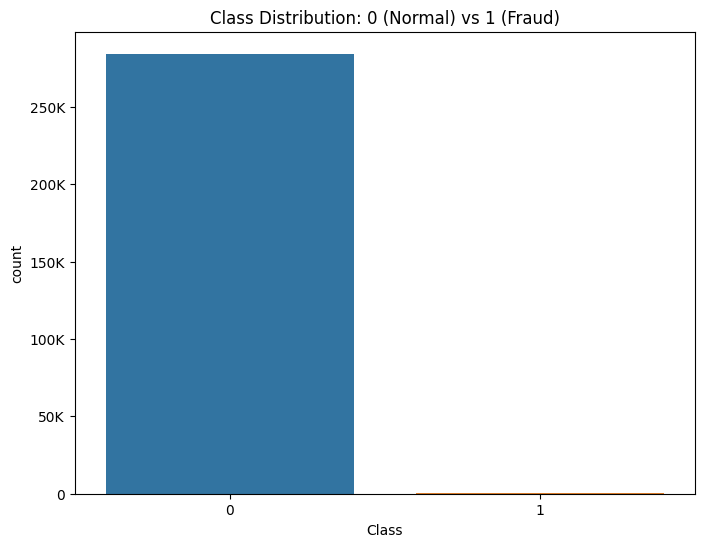

In [ ]:
# Distribution of non-fraud and fraud cases
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution: 0 (Normal) vs 1 (Fraud)")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [ ]:
# Count and print unique transaction amounts
print(df["Amount"].value_counts())

Amount
1.00       13688
1.98        6044
0.89        4872
9.99        4747
15.00       3280
           ...  
62.09          1
552.05         1
1467.75        1
196.68         1
95.63          1
Name: count, Length: 32767, dtype: int64


In [ ]:
# Show percentage distribution of transaction amounts
df["Amount"].value_counts(normalize=True)

Amount
1.00       0.048061
1.98       0.021221
0.89       0.017106
9.99       0.016667
15.00      0.011517
             ...   
62.09      0.000004
552.05     0.000004
1467.75    0.000004
196.68     0.000004
95.63      0.000004
Name: proportion, Length: 32767, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


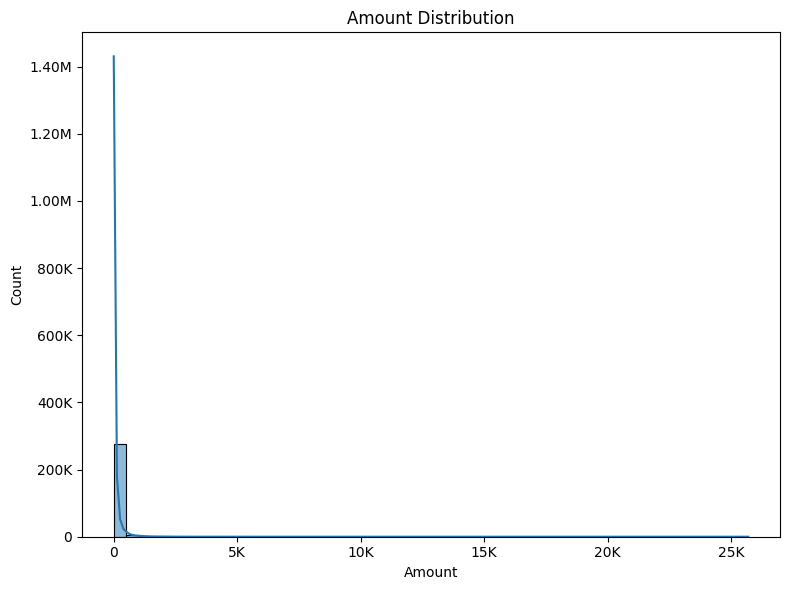

In [ ]:
# Distribution of transaction Amount
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Amount Distribution")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [ ]:
# Count and print unique transaction times (duration)
print(df["Time"].value_counts())

Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
127750.0     1
62260.0      1
62259.0      1
127753.0     1
172792.0     1
Name: count, Length: 124592, dtype: int64


In [ ]:
# Show percentage distribution of transaction times (duration)
df["Time"].value_counts(normalize=True)

Time
163152.0    0.000126
64947.0     0.000091
68780.0     0.000088
3767.0      0.000074
3770.0      0.000070
              ...   
127750.0    0.000004
62260.0     0.000004
62259.0     0.000004
127753.0    0.000004
172792.0    0.000004
Name: proportion, Length: 124592, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


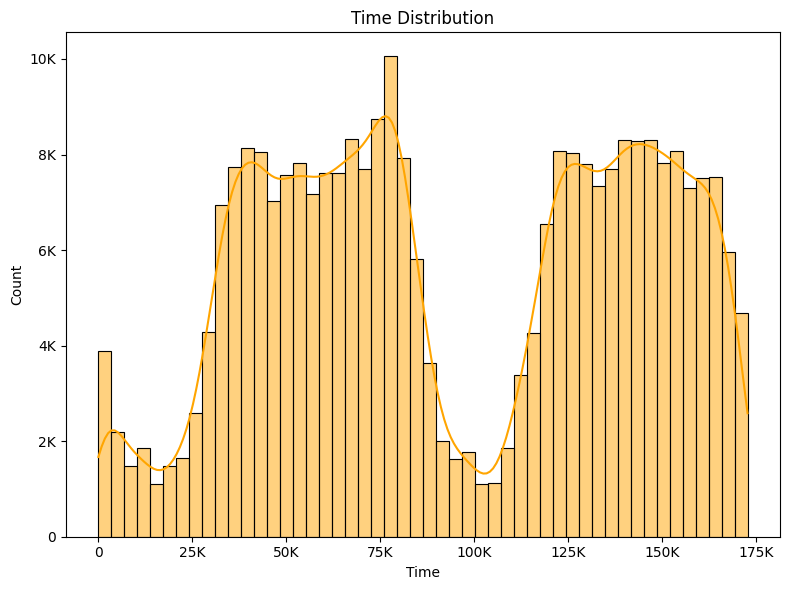

In [ ]:
# Distribution of Time duration between transactions
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.histplot(df["Time"], bins=50, kde=True, color="orange")
plt.title("Time Distribution")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

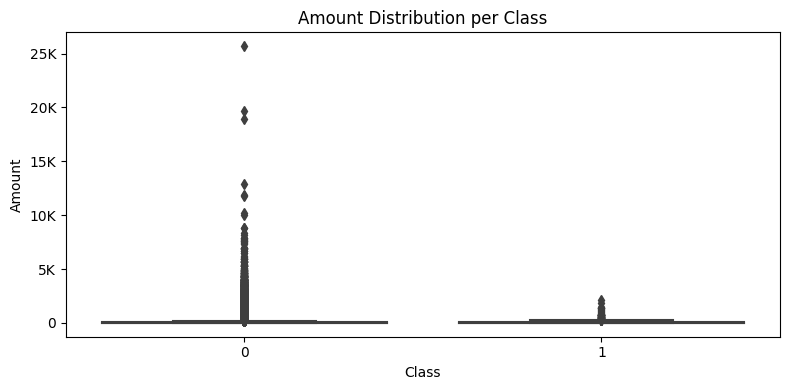

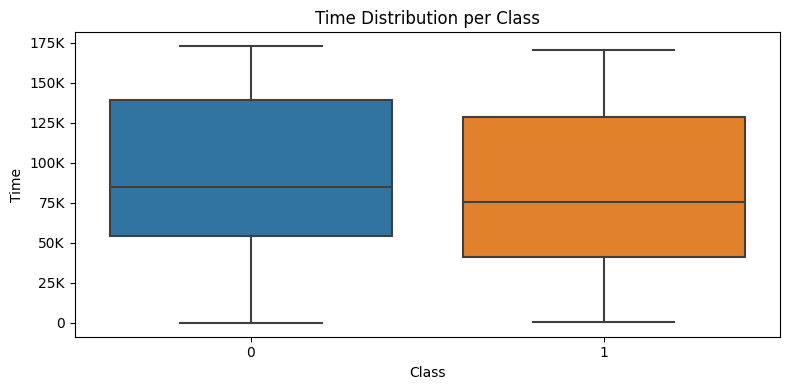

In [ ]:
# Distribution of Time and Amount per Class (0=non-fraud, 1=fraud case)
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

# Boxplot Figure 1: Amount vs Class
plt.figure(figsize=(8,4))
sns.boxplot(x="Class", y="Amount", data=df)
plt.title("Amount Distribution per Class")

ax1 = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax1.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# Boxplot Figure 2: Time vs Class
plt.figure(figsize=(8,4))
sns.boxplot(x="Class", y="Time", data=df)
plt.title("Time Distribution per Class")

ax2 = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

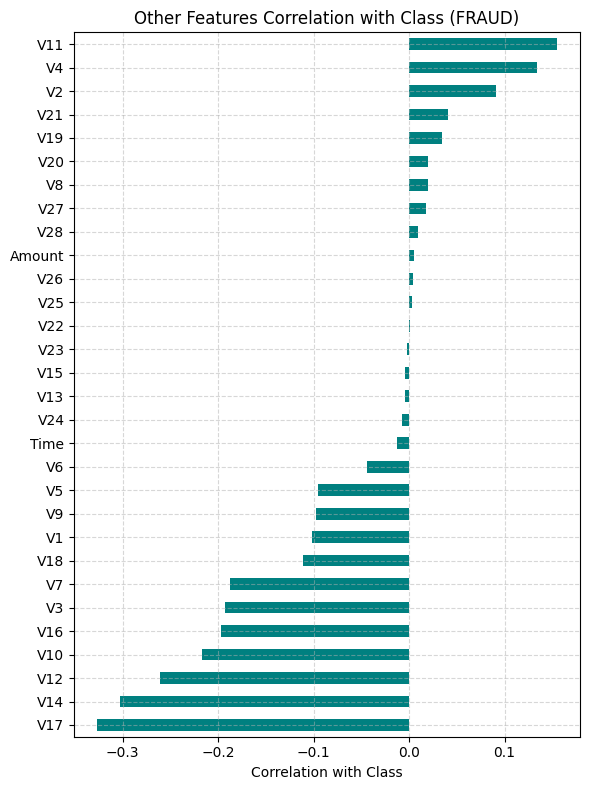

In [ ]:
# Correlation between Features and Class 1 (Fraud)
correlations = df.corr()["Class"].drop("Class").sort_values()

plt.figure(figsize=(6, 8))
correlations.plot(kind="barh", color="teal")

plt.title("Other Features Correlation with Class (FRAUD)")
plt.xlabel("Correlation with Class")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## III. DATA PREPARATION

Usually for data preparation part (preprocessing), what I'm going to do is as following:
1. Handling missing values.
2. Handling duplicated values.
3. Checking data distribution.
4. Handling outliers.

But I already did some of them in part 2. LOAD AND CHECK THE DATASET, especially during EDA steps. But as a reminder for me, I'm going to do them anyway.

### 1. Handling Missing Values

After I checked the dataset, there are no missing values inside the dataset.

In [ ]:
# Check the number of missing values in each column of the dataset
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### 2. Handling Duplicated Values

In [ ]:
# Show all rows that are duplicates (keeping and showing all occurrences)
df[df.duplicated(keep=False)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284190,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284192,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,...,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0


In [ ]:
# Show duplicates based only on Time, Amount, and Class features
df[df.duplicated(subset=["Time", "Amount", "Class"], keep=False)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
108,73.0,1.162281,1.248178,-1.581317,1.475024,1.138357,-1.020373,0.638387,-0.136762,-0.805505,...,-0.124012,-0.227150,-0.199185,-0.289757,0.776244,-0.283950,0.056747,0.084706,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284193,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,...,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0
284248,172273.0,-0.765414,1.343887,-0.306101,-0.645545,-0.067358,-1.172196,0.516073,0.342927,0.368227,...,-0.289752,-0.709882,0.173594,-0.064594,-0.420300,0.159895,0.330875,0.150175,1.98,0
284251,172273.0,2.061056,-0.077031,-1.068720,0.422266,-0.181192,-1.227747,0.160285,-0.314824,0.596385,...,-0.292782,-0.727558,0.345553,0.036287,-0.312041,0.196591,-0.073152,-0.060601,1.98,0
284328,172348.0,2.064806,0.008284,-2.226901,0.926502,1.119908,0.178604,0.349210,-0.010441,0.262333,...,0.006761,0.087820,-0.095232,-0.452246,0.532753,-0.468378,-0.036697,-0.079256,11.99,0


In [ ]:
# Count the total number of duplicated rows (keeping the first occurrence as non-duplicate)
df.duplicated().sum()

1081

In [ ]:
# Count the total number of duplicated rows (marking all duplicates as True)
df.duplicated(keep=False).sum()

1854

In [ ]:
# Count the number of unique duplicated rows (after dropping exact duplicates)
df[df.duplicated(keep=False)].drop_duplicates().shape[0]

773

In [ ]:
# Show the distribution of Class values among duplicated rows
df[df.duplicated(keep=False)]["Class"].value_counts()

Class
0    1822
1      32
Name: count, dtype: int64

- There are 1,822 duplicats on Class 0 (non-fraud) and 32 duplicats on Class 1 (fraud).

- Since Class 1 has few duplicats, I decided not too drop the duplicats.

- I will only drop the duplicats from Class 0.

In [ ]:
# Separating Class between 0 and 1
fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0]

# Drop duplicated values from Class 0 only
non_fraud_cleaned = non_fraud.drop_duplicates()

# Combined both Classes and renamed the dataset as df_cleaned
# Duplicated values of Class 0 have been dropped from the dataset
df_cleaned = pd.concat([fraud, non_fraud_cleaned], ignore_index=True)

In [ ]:
# Count duplicates in the cleaned dataset (df_cleaned)
df_cleaned.duplicated().sum()

19

In [ ]:
# Check Class distribution in duplicates of the cleaned dataset
df_cleaned[df_cleaned.duplicated(keep=False)]["Class"].value_counts()

Class
1    32
Name: count, dtype: int64

In [ ]:
# Show the percentage distribution of unique values in the Class feature
df_cleaned["Class"].value_counts(normalize=True) * 100

Class
0    99.826605
1     0.173395
Name: proportion, dtype: float64

#### 3. Checking Data Distribution

**A. Feature Distribution between Fraud and Non-fraud Transactions**

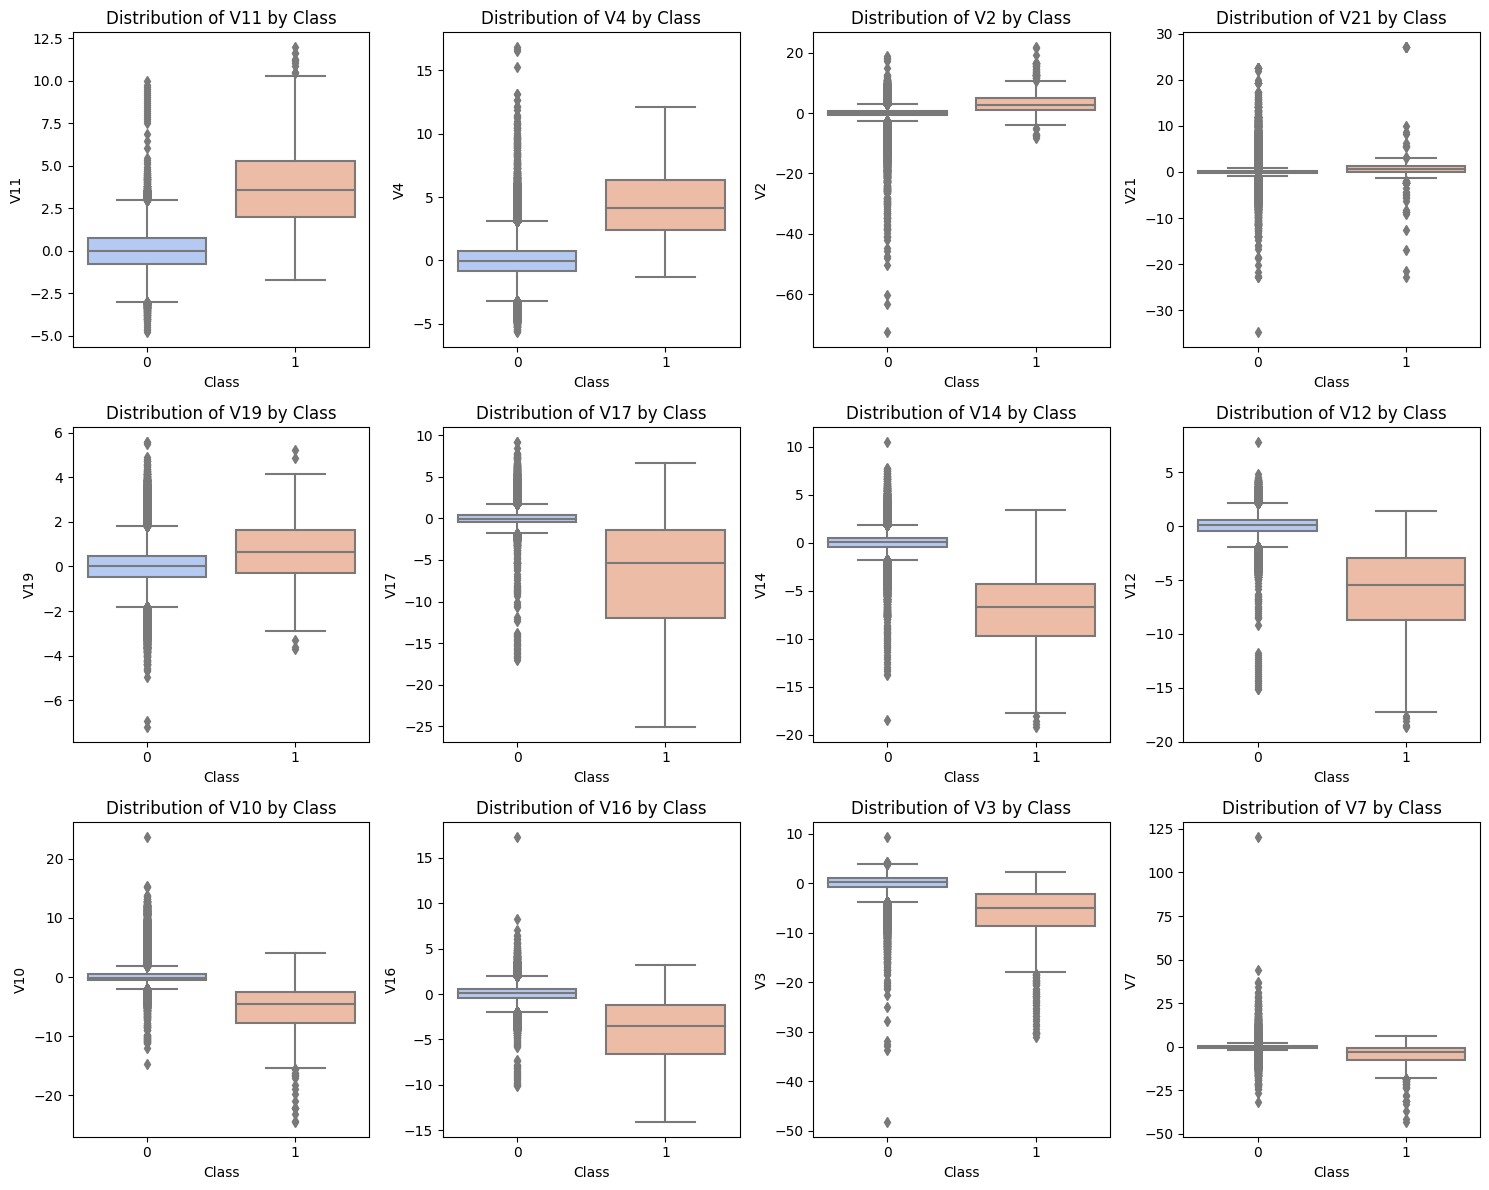

In [ ]:
# Selected features based on Strongest Positive and Strongest Negative correlations with Class
selected_features = ['V11', 'V4', 'V2', 'V21', 'V19', # Strong Positive
                     'V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7']  # Strong Negative

plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data=df_cleaned, x='Class', y=feature, palette="coolwarm")
    plt.title(f'Distribution of {feature} by Class')
plt.tight_layout()
plt.show()

**B. Outlier Visualization with Boxplots**

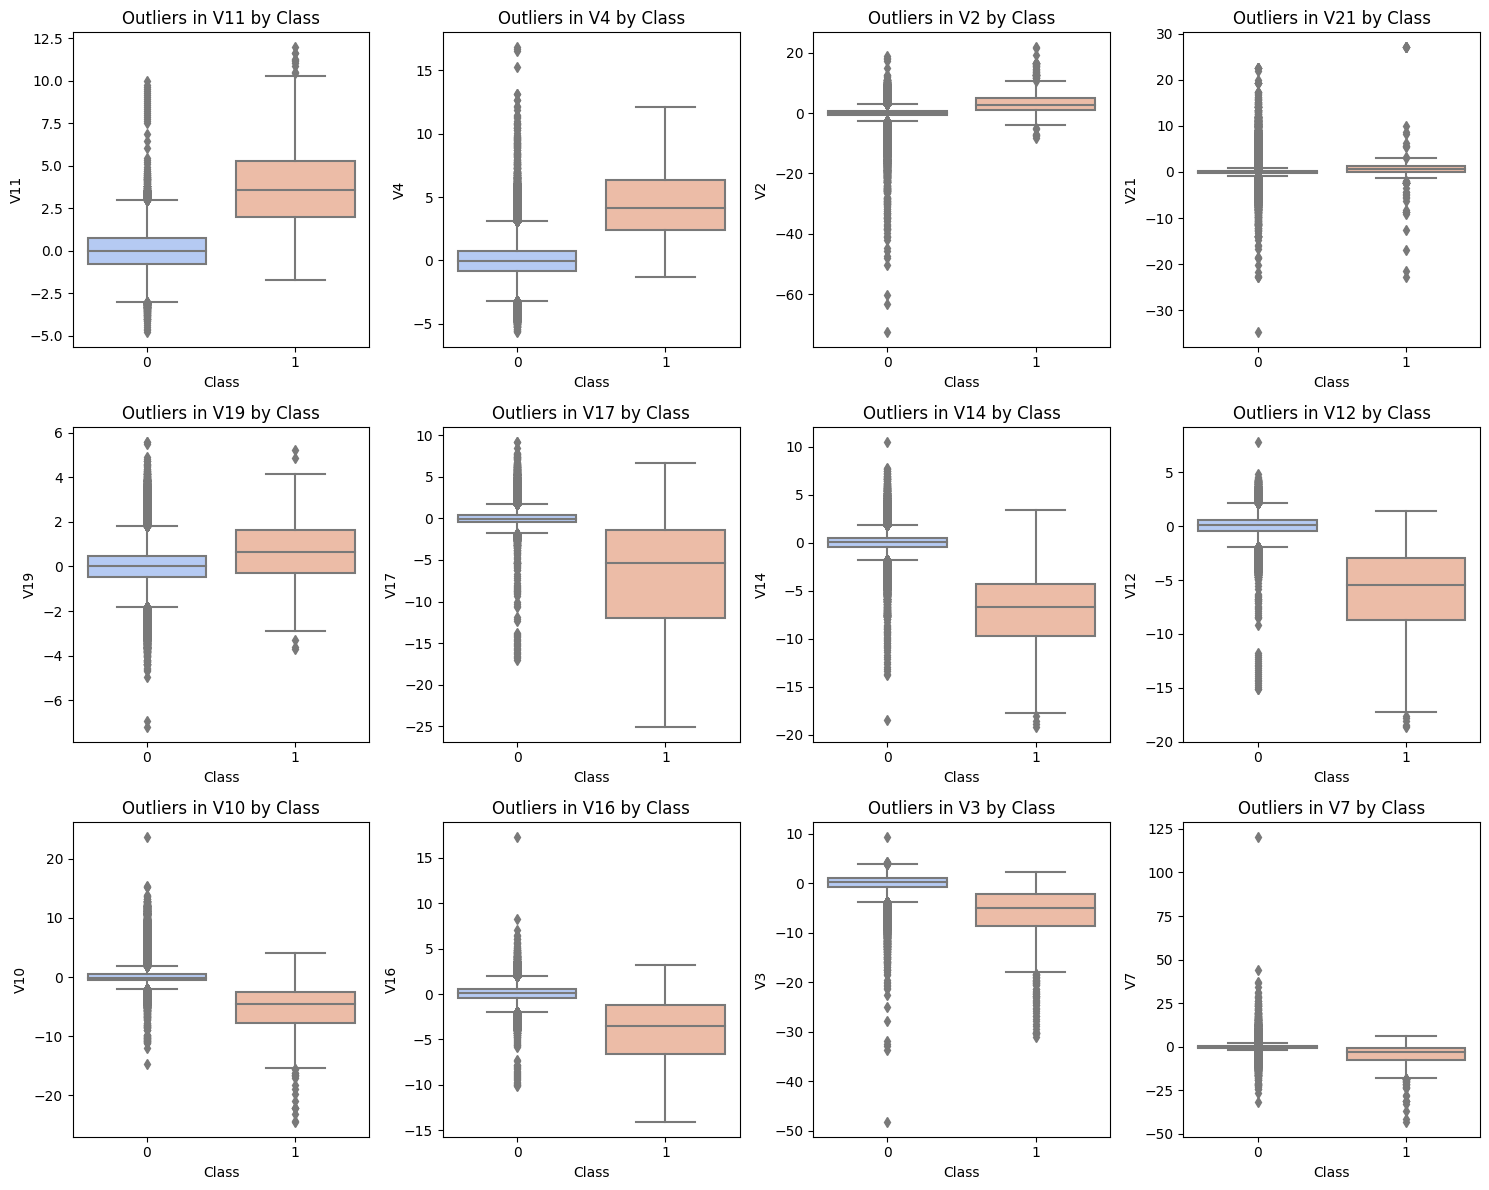

In [ ]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data=df_cleaned, x='Class', y=feature, palette="coolwarm")
    plt.title(f'Outliers in {feature} by Class')
plt.tight_layout()
plt.show()

**C. Histogram for Transaction Amount**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


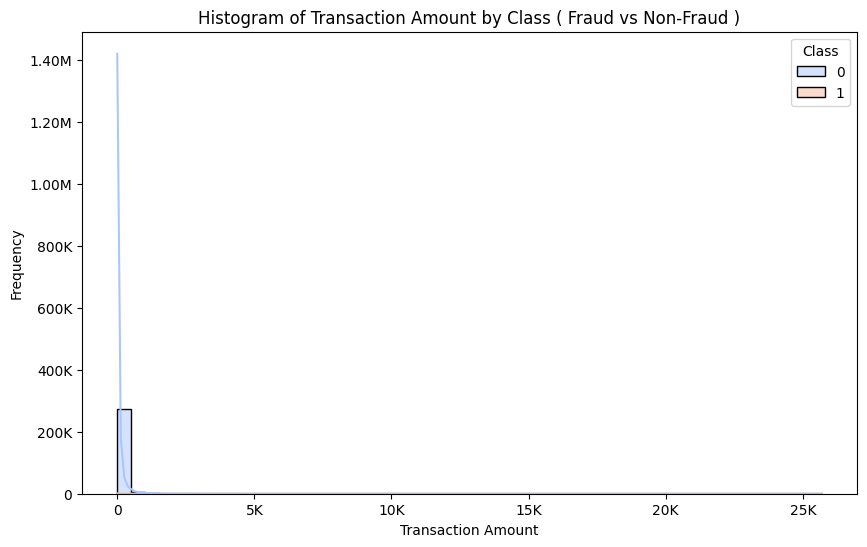

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned, x='Amount', hue='Class', kde=True, palette="coolwarm", bins=50)
plt.title('Histogram of Transaction Amount by Class ( Fraud vs Non-Fraud )')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

ax1 = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax1.yaxis.set_major_formatter(formatter)
ax1.xaxis.set_major_formatter(formatter)

plt.show()

#### 4. Handling Outliers

I have decided not to drop any outliers. Outliers were retained because they may represent real fraudulent behavior, which is inherently anomalous. Removing them could reduce the model’s ability to detect rare but significant fraud patterns.

## IV. DATA MANIPULATION

As for this part, I'm going to scale only `Amount` and `Time`, because the rest of the features which is `V1` until `V28` have been standardized by `PCA (Principal Component Analysis)`. While `Amount` and `Time` features are still in their original version.

`PCA (Principal Component Analysis)` is a method to simplify complex data by combining and reducing lots of information into a smaller set of key points or components while keeping the most useful parts of the data.

For example, if I'm analyzing customers' Income and Spending Habits, PCA might find that both of them are closely related. PCA will create a new single measure called 'Financial Activity' to represent both of them in a much simpler way, therefore making them easier to visualize and analyze without omitting much information.

In [ ]:
# Standardizing only Amount and Time features
scaler = StandardScaler()
df_cleaned[['Amount_scaled', 'Time_scaled']] = scaler.fit_transform(df_cleaned[['Amount', 'Time']])

# Drop the original Amount and Time columns before modelling process
# Create and use the new dataset (df_model) to preserve the original one (df_cleaned)
df_model = df_cleaned.drop(columns=['Amount', 'Time'])

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283745 entries, 0 to 283744
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             283745 non-null  float64
 1   V2             283745 non-null  float64
 2   V3             283745 non-null  float64
 3   V4             283745 non-null  float64
 4   V5             283745 non-null  float64
 5   V6             283745 non-null  float64
 6   V7             283745 non-null  float64
 7   V8             283745 non-null  float64
 8   V9             283745 non-null  float64
 9   V10            283745 non-null  float64
 10  V11            283745 non-null  float64
 11  V12            283745 non-null  float64
 12  V13            283745 non-null  float64
 13  V14            283745 non-null  float64
 14  V15            283745 non-null  float64
 15  V16            283745 non-null  float64
 16  V17            283745 non-null  float64
 17  V18            283745 non-nul

## V. MODELLING PREPARATION (part 1)

In this phase, I will prepare the dataset to be used for TRAINING and TESTING the model. The steps will include:

1. Separate input features (X) and target variable (y).
2. Split the dataset into TRAINING and TESTING datasets.
3. Balance the TRAINING dataset using SMOTE.
4. **Baseline model training using RandomForestClassifier**.
5. Evaluate the model performance on the original imbalanced TEST dataset.

I will use SMOTE because it helps improve model sensitivity **(recall)** for detecting fraudulent transactions in an imbalanced dataset.

In [ ]:
# 1. Separate features (X) and target (y)
X = df_model.drop('Class', axis=1)
y = df_model['Class']

In [ ]:
# 2. Split into TRAIN and TEST datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model_results = {}

In [ ]:
# 3. Apply SMOTE to balance the TRAIN dataset ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# The function to extract evaluation metrics from each model
def get_model_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    return [precision, recall, f1, roc_auc, pr_auc]

# The function above is only run once before the 1st model training
# It doesn't need to be run on every model training session
# It allows the notebook to save model evaluation to be evaluated later

In [ ]:
# 4. Train the model using RandomForestClassifier algorithm
# The TRAIN dataset has been balanced with SMOTE
baseline_smote_model = RandomForestClassifier(random_state=42)
baseline_smote_model.fit(X_train_smote, y_train_smote)

# Save evaluation result info a dictionary
scores = get_model_scores(baseline_smote_model, X_test, y_test)
model_results["RF - Baseline SMOTE"] = scores

print(f"Model: RF - Baseline SMOTE")
y_pred = baseline_smote_model.predict(X_test)
y_proba = baseline_smote_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, baseline_smote_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

Model: RF - Baseline SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.90      0.66      0.76        98

    accuracy                           1.00     56749
   macro avg       0.95      0.83      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC: 0.9533929368467656
PR-AUC: 0.742652716580491


In [ ]:
# 5. Predict using original TEST dataset
y_proba = baseline_smote_model.predict_proba(X_test)[:, 1] # Probability for Class 1 (fraud)
y_pred = baseline_smote_model.predict(X_test) # Prediction for Class 0 (normal) or Class 1 (fraud)

## VI. MODELLING EVALUATION (part 1)

In this part, I will show the evaluation result like Confusion Matrix, Classification Report, and ROC-AUC Score of my **baseline_smote_model** which has been trained with **SMOTE balancing** and **RandomForestClassifier** algorithm.

In [ ]:
# Baseline model evaluation after applying RandomForestClassifier and balancing the TRAIN dataset with SMOTE
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_proba))

[[56644     7]
 [   33    65]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.90      0.66      0.76        98

    accuracy                           1.00     56749
   macro avg       0.95      0.83      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC Score: 0.9533929368467656
PR-AUC Score: 0.742652716580491


##### Based on the results above, here is my evaluation of the **baseline_smote_model** ability to detect Class 1 (fraud):

**A. Confusion Matrix**
1. 56,664 transactions were correctly recognized as non-fraud *(True Negatives)*.
2. 7 transactions were mistakenly flagged as fraud *(False Positives)*.
3. 65 fraudulent transactions were successfully detected *(True Positives)*.
4. 33 fraudulent transactions slipped through and were not caught by the model *(False Negatives)*.

**B. Classification Report of Class 1 (Fraud)**
1. **Precision** score 0.90 --> 90% of flagged fraud cases were truly fraud, indicating very few false positives.
2. **Recall** score 0.66 -->  the model missed 34% fraud cases, it definitely **needs improvement**.
3. **F1-score** 0.76 --> an acceptable performance, but overshadowed with **low Recall score**.
4. **ROC-AUC** score 0.95 --> strong overall ability to distinguish fraud from non-fraud cases.
5. **PR-AUC** score 0.74 --> good fraud detection confidence in an imbalanced dataset.

In conclusion, **baseline_smote_model** demonstrated high Precision score with very few false alarms (False Positives) but lower Recall score, indicating it missed a significant portion of fraud cases. **Improving Recall score is necessary** for better fraud detection coverage.

## VII. MODELLING IMPROVEMENT (part 1)

In this part, I'm going to try to use **OPTUNA** for **hyperparameter tuning** on **RandomForestClassifier** with **SMOTE**-balanced dataset. The objective is to improve Recall score and F-1 score.

In [ ]:
# 1. Separate features (X) and target (y)
X = df_model.drop("Class", axis=1)
y = df_model["Class"]

In [ ]:
# 2. Split into TRAIN and TEST datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# 3. Apply SMOTE to the TRAINING set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# 4. Define OPTUNA objective function for Hyperparameter Tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 50, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    # Train model on SMOTE-balanced training set
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    model.fit(X_train_smote, y_train_smote)

    # Predict probabilities on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Tune decision threshold
    threshold = trial.suggest_float("threshold", 0.3, 0.7)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Return F1-score on Class 1 (Fraud) as the objective to maximize
    return f1_score(y_test, y_pred, pos_label=1)

In [ ]:
# 5. Start the Optuna study to optimize the model
study_randomforest = optuna.create_study(direction="maximize")
study_randomforest.optimize(objective, n_trials=50, timeout=3600)

[I 2025-06-06 08:58:56,946] A new study created in memory with name: no-name-3ea37bb8-cdbd-4964-9a9a-dd9b2790a7ea
[I 2025-06-06 09:03:27,327] Trial 0 finished with value: 0.7570621468926554 and parameters: {'n_estimators': 118, 'max_depth': 68, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'threshold': 0.5113599659461073}. Best is trial 0 with value: 0.7570621468926554.
[I 2025-06-06 09:32:58,142] Trial 1 finished with value: 0.41420118343195267 and parameters: {'n_estimators': 108, 'max_depth': 94, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': None, 'threshold': 0.3017515708939877}. Best is trial 0 with value: 0.7570621468926554.
[I 2025-06-06 09:35:57,571] Trial 2 finished with value: 0.7666666666666667 and parameters: {'n_estimators': 102, 'max_depth': 64, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'threshold': 0.5206903998316516}. Best is trial 2 with value: 0.7666666666666667.
[I 2025-06-06 09:38:57,544] Trial

In [ ]:
# 6. Retrieve best params and threshold
best_params = study_randomforest.best_params.copy()
best_threshold = best_params.pop("threshold")  # Remove threshold from params

In [ ]:
# 7. Retrain the model using the best parameters
baseline_smote_optuna_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
baseline_smote_optuna_model.fit(X_train_smote, y_train_smote)

# Save evaluation result info a dictionary
scores = get_model_scores(baseline_smote_optuna_model, X_test, y_test)
model_results["RF - SMOTE + Optuna"] = scores

print(f"Model: RF - SMOTE + Optuna")
y_pred = baseline_smote_optuna_model.predict(X_test)
y_proba = baseline_smote_optuna_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, baseline_smote_optuna_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

Model: RF - SMOTE + Optuna
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.86      0.67      0.75        98

    accuracy                           1.00     56749
   macro avg       0.93      0.84      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC: 0.9748421142123687
PR-AUC: 0.7466098109470661


In [ ]:
# 8. Predict before evaluation
y_pred = baseline_smote_optuna_model.predict(X_test)
y_proba = baseline_smote_optuna_model.predict_proba(X_test)[:, 1]

In [ ]:
# 9. Evaluate the final model performance of OPTUNA Hyperparameter Tuning on RandomForestClassifier with a SMOTE-balanced dataset
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_proba))

[[56640    11]
 [   32    66]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.86      0.67      0.75        98

    accuracy                           1.00     56749
   macro avg       0.93      0.84      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC Score: 0.9748421142123688
PR-AUC Score: 0.7466098109470661


#### Based on the results above, here is my evaluation of the **baseline_smote_optuna_model** ability to detect Class 1 (Fraud):

**A. Confusion Matrix**
1. 56,640 transactions were correctly recognized as non-fraud *(True Negatives)*.
2. 11 transactions were incorrectly flagged as fraud *(False Positives)*.
3. 66 fraudulent transactions were successfully detected *(True Positives)*.
4. 32 fraudulent transactions were missed and classified as non-fraud *(False Negatives)*.

**B. Classification Report of Class 1 (Fraud)**
1. **Precision** score 0.86 --> it correctly indicates that most flagged transactions were indeed fraudulent, although slightly lower than the untuned model.
2. **Recall** score 0.67 --> it indicates a decent level of Recall, slightly more fraud cases were caught compared to untuned model.
3. **F1-score** 0.75 --> it indicates a balanced trade-off between Precision and Recall, which means the model is relatively consistent in detecting fraud, only slightly lower  than the untuned model..
4. **ROC-AUC** score 0.97 --> the model has an excellent ability to separate legitimate and fraudulent transactions, only slightly better than the untuned model.
5. **PR-AUC** score 0.75 --> it reflects high reliability in predicting fraud cases, very important in imbalanced dataset and only slightly better than the untuned model.

In conclusion, the **baseline_smote_optuna_model** demonstrated strong and balanced performance in fraud detection.
- It minimized false alarms *(low False Positives)*.
- Maintained high Precision.
- Managed to capture a substantial portion of fraud cases.

It comes with a slight drop in Precision score, resulting in generating more false alarms (False Positives) compared to the previously untuned model.

If the priority is **detecting as many frauds as possible**, even with a few extra false positives, **baseline_smote_optuna_model** is a better choice.

If **minimizing false positives** is more important (reducing Fraud Analyst workload), then the **untuned baseline_smote_model** might be preferred.

This **baseline_smote_optuna_model** achieved a good balanced between risk **(missed fraud cases)** and cost **(manual review of false alarms)**.

In real-world deployment, this kind of trade-off is still acceptable, especially when catching more fraud cases could make the company avoid significant financial or reputational loss.

I have compared these 2 **RandomForestClassifier** models,
1. **baseline_smote_model** (SMOTE + RandomForestClassifier).
2. **baseline_smote_optuna_model** (Optuna + SMOTE + RandomForestClassifier).

Now, I'm going to try experimenting with XGBoost algorithm for the next part.

## V. MODELLING PREPARATION (part 2)

Right now, I'm going to apply **SMOTE balancing** on the train dataset and after that, I will train the model using **XGBoost**. The objective to make a comparison to define which model works best to detect fraudulent transactions, other than RandomForestClassifier on the last part.

In [ ]:
# 1. Separate features (X) and target (y)
X = df_model.drop('Class', axis=1)
y = df_model['Class']

In [ ]:
# 2. Split into TRAIN and TEST datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 3. Apply SMOTE to balance the TRAIN dataset ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# 4. Train the model using XGBoost algorithm
# The TRAIN dataset has been balanced with SMOTE
xgb_smote_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_smote_model.fit(X_train_smote, y_train_smote)

# Save evaluation result info a dictionary
scores = get_model_scores(xgb_smote_model, X_test, y_test)
model_results["XGB - SMOTE"] = scores

print(f"Model: XGB - SMOTE")
y_pred = xgb_smote_model.predict(X_test)
y_proba = xgb_smote_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, xgb_smote_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGB - SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.78      0.72      0.75        98

    accuracy                           1.00     56749
   macro avg       0.89      0.86      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC: 0.9723617465909242
PR-AUC: 0.7496381817099266


## VI. MODELLING EVALUATION (part 2)

In [ ]:
# 5. Predict using original TEST dataset
y_pred = xgb_smote_model.predict(X_test)
y_proba = xgb_smote_model.predict_proba(X_test)[:, 1]

# Baseline model evaluation after applying XGBoost and balancing with SMOTE
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_proba))

[[56631    20]
 [   27    71]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.78      0.72      0.75        98

    accuracy                           1.00     56749
   macro avg       0.89      0.86      0.88     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC Score: 0.9723617465909242
PR-AUC Score: 0.7496381817099266


##### Based on the results above, here is my evaluation of the **xgb_smote_model** ability to detect Class 1 (Fraud):

**A. Confusion Matrix**
1. 56,631 transactions were correctly recognized as non-fraud *(True Negatives)*.
2. 20 transactions were mistakenly flagged as fraud *(False Positives)*.
3. 71 fraud transactions were successfully detected *(True Positives)*.
4. 27 fraud transactions slipped through and were not caught by the model *(False Negatives)*.

**B. Classification Report of Class 1 (Fraud)**
1. **Precision** score 0.78 --> 78% of transactions predicted as fraud were truly fraud.
2. **Recall** score 0.72 --> 72% of actual fraud cases were correctly detected.
3. **F1-score** 0.75 --> a balanced score, reflecting the trade-off between Precision and Recall.
4. **ROC-AUC** score 0.97 --> a strong overall scorein in discriminating fraud & non-fraud cases.
5. **PR-AUC** score 0.75 --> a reliable performance in fraud detection in an imbalanced dataset.

In conclusion, the **xgb_smote_model** demonstrated strong performance in detecting fraud cases with a good balance between false positives and false negatives. It successfully identified the majority of fraud cases with relatively few false alarms, making it an effective model for fraud detection.

## VII. MODELLING IMPROVEMENT (part 2)

In this part, I'm going to try to use **OPTUNA** for **hyperparameter tuning** on **XGBoost** with **SMOTE**-balanced dataset. The objective is to improve xgb_smote_model ability in detecting fraudulent transactions.

In [ ]:
# 1. Separate features (X) and target (y)
X = df_model.drop('Class', axis=1)
y = df_model['Class']

In [ ]:
# 2. Split into TRAIN and TEST datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 3. Apply SMOTE to balance the TRAIN dataset ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# 4. Define the Optuna objective function for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 50, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "tree_method": "hist"
    }

    model = XGBClassifier(**params)
    model.fit(X_train_smote, y_train_smote)

    y_pred = model.predict(X_test)
    return average_precision_score(y_test, y_pred) # To optimize PR-AUC

In [ ]:
# 5. Start the Optuna study to optimize the model
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=3600)

[I 2025-06-06 10:21:59,654] A new study created in memory with name: no-name-9c38d9f3-7c55-4efd-8cab-7365cd0d8ea8
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:22:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-06 10:22:04,859] Trial 0 finished with value: 0.5860987545432402 and parameters: {'n_estimators': 113, 'max_depth': 51, 'learning_rate': 0.23794114057026194, 'subsample': 0.7927886235209266, 'colsample_bytree': 0.6308564195659094, 'gamma': 0.6653388818414296, 'reg_lambda': 8.292528449021916, 'reg_alpha': 7.842363031219624}. Best is trial 0 with value: 0.5860987545432402.
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-06 10:22:10,214] Trial 1 finished with v

In [ ]:
# 6. Train the final model using best parameters
best_params = study.best_params
best_params["random_state"] = 42
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

xgb_smote_optuna_model = XGBClassifier(**best_params)
xgb_smote_optuna_model.fit(X_train_smote, y_train_smote)

# Save evaluation result info a dictionary
scores = get_model_scores(xgb_smote_optuna_model, X_test, y_test)
model_results["XGB - SMOTE + Optuna"] = scores

print(f"XGB - SMOTE + Optuna")
y_pred = xgb_smote_optuna_model.predict(X_test)
y_proba = xgb_smote_optuna_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, xgb_smote_optuna_model.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:27:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB - SMOTE + Optuna
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.77      0.79        98

    accuracy                           1.00     56749
   macro avg       0.90      0.88      0.89     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC: 0.9743452481520402
PR-AUC: 0.7629121932900135


In [ ]:
# 7. Evaluate model on the original test set
y_pred = xgb_smote_optuna_model.predict(X_test)
y_proba = xgb_smote_optuna_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_proba))

Confusion Matrix:
 [[56633    18]
 [   23    75]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.77      0.79        98

    accuracy                           1.00     56749
   macro avg       0.90      0.88      0.89     56749
weighted avg       1.00      1.00      1.00     56749

ROC-AUC Score: 0.9743452481520402
PR-AUC Score: 0.7629121932900135


#### Based on the results above, here is my evaluation of the **xgb_smote_optuna_model** ability to detect Class 1 (Fraud):

**A. Confusion Matrix**
1. 56,633 transactions were correctly recognized as non-fraud *(True Negatives)*.
2. 18 legitimate transactions were mistakenly flagged as fraud *(False Positives)*.
3. 75 fraudulent transactions were successfully detected *(True Positives)*.
4. 23 fraudulent transactions slipped through undetected *(False Negatives)*.

**B. Classification Report of Class 1 (Fraud)**
1. **Precision** score 0.81 --> 81% of transactions predicted as fraud were actually fraud, indicating strong reliability.
2. **Recall** score 0.77 --> the model successfully caught 77% of actual fraud cases.
3. **F1-score** 0.79 --> it indicates a well-balanced performance between Precision and Recall.
4. **ROC-AUC** score 0.97 --> the model has excellent ability to distinguish and separate fraudulent & legitimate transactions.
5. **PR-AUC** score 0.76 --> it indicates high effectiveness in identifying fraudulent transactions in an imbalanced dataset.

Most scores of the **xgb_smote_optuna_model** were better than the scores of the xgb_smote_model, excluding ROC-AUC score which was equal. It managed to to deliver a strong yet well-balanced performance in fraud detection compared to untuned counterpart which is xgb_smote_model.

- It improved Recall, meaning that the model caught more fraud cases.
- It maintained high Precision which kept False Positives relatively low.
- It achieved the highest PR-AUC and ROC-AUC among other models so far.

The **xgb_smote_optuna_model** effectively balances the trade-off between minimizing missed frauds **(False Negatives)** and limiting false alarms **(False Positives)**.

In conclusion, the **xgb_smote_optuna_model** stands out as a highly practical and robust choice for fraud detection, especially in real-world settings where both accuracy and efficiency are essential.

## VIII. MODEL COMPARISON

I have trained 4 kinds of model in the previous sections. The models are as following,
1. baseline_smote_model (**RandomForest + SMOTE**).
2. baseline_smote_optuna_model (**RandomForest + SMOTE + Optuna**).
3. xgb_smote_model (**XGBoost + SMOTE**).
4. xgb_smote_optuna_model (**XGBoost+SMOTE + Optuna**).

I'm going to use a **grouped bar chart** to visualize each model's evaluation scores in detecting **fraud cases (Class 1)**.

In [ ]:
# 1. Dictionary of trained models
models = {
    "RF - Baseline SMOTE": baseline_smote_model,
    "RF - SMOTE + Optuna": baseline_smote_optuna_model,
    "XGB - SMOTE": xgb_smote_model,
    "XGB - SMOTE + Optuna": xgb_smote_optuna_model
}

In [ ]:
# 2. A dictionary to store evaluation results of all trained models
model_results = {}

In [ ]:
# 3. Automatically evaluate each model
for name, model in models.items():
    scores = get_model_scores(model, X_test, y_test)
    model_results[name] = scores

In [ ]:
# ===== VISUALIZATION with GROUPED BAR CHART ===== #

# 4. Visualization: Grouped Bar Chart
def plot_grouped_bar_chart(model_results):
    labels = ["Precision (cls=1)", "Recall (cls=1)", "F1-Score (cls=1)", "ROC-AUC (proba)", "PR-AUC (proba)"]
    label_mapping = {
        "Precision (cls=1)": "Precision",
        "Recall (cls=1)": "Recall",
        "F1-Score (cls=1)": "F1-Score",
        "ROC-AUC (proba)": "ROC-AUC",
        "PR-AUC (proba)": "PR-AUC"
}

    # Convert model_results into a dictionary grouped by metric
    model_scores = {metric: [] for metric in label_mapping.values()}
    for scores in model_results.values():
        for i, metric in enumerate(model_scores.keys()):
            model_scores[metric].append(scores[i])

    x = np.arange(len(labels))
    width = 0.2
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['red', 'lightskyblue', 'orange', 'navy']
    for i, model_name in enumerate(model_results.keys()):
        scores = [model_results[model_name][j] for j in range(len(labels))]
        ax.bar(x + i * width, scores, width, label=model_name)

    ax.set_ylabel('Score')
    ax.set_title('Model Evaluation Metrics Comparison of Fraud Detection (Class 1)')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.1)
    ax.legend(loc='lower right')

    # Add score values above each bar
    for i, model_name in enumerate(models.keys()):
        for j, score in enumerate([model_scores[label_mapping[metric]][i] for metric in labels]):
            ax.text(x[j] + i * width, score + 0.01, f"{score:.2f}", ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

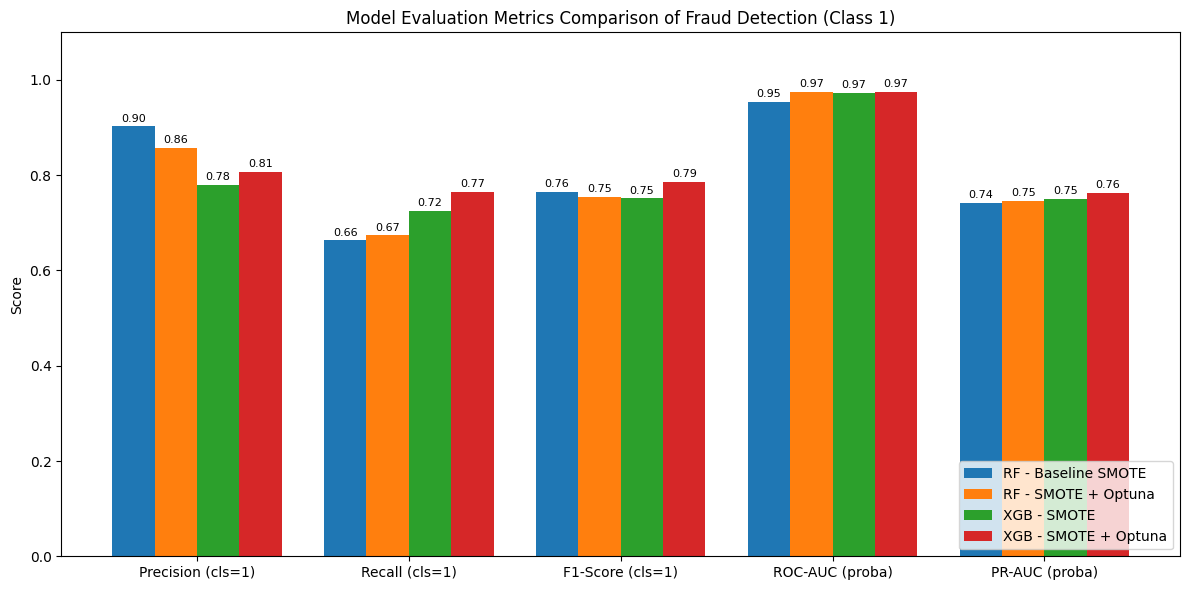

In [ ]:
# 5. Call and run the Visualization Function
plot_grouped_bar_chart(model_results)

In [ ]:
# 6. Convert dictionary to DataFrame for visualization in table format
print("Scores Evaluation of model_results:", model_results)
df_results = pd.DataFrame(model_results, index=["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"])
display(df_results)

Scores Evaluation of model_results: {'RF - Baseline SMOTE': [0.9027777777777778, 0.6632653061224489, 0.7647058823529411, 0.9533929368467656, 0.742652716580491], 'RF - SMOTE + Optuna': [0.8571428571428571, 0.673469387755102, 0.7542857142857143, 0.9748421142123687, 0.746609810947066], 'XGB - SMOTE': [0.7802197802197802, 0.7244897959183674, 0.7513227513227513, 0.9723617465909242, 0.7496381817099266], 'XGB - SMOTE + Optuna': [0.8064516129032258, 0.7653061224489796, 0.7853403141361257, 0.9743452481520402, 0.7629121932900135]}


,RF - Baseline SMOTE,RF - SMOTE + Optuna,XGB - SMOTE,XGB - SMOTE + Optuna
Precision,0.902778,0.857143,0.780220,0.806452
Recall,0.663265,0.673469,0.724490,0.765306
F1-Score,0.764706,0.754286,0.751323,0.785340
ROC-AUC,0.953393,0.974842,0.972362,0.974345
PR-AUC,0.742653,0.746610,0.749638,0.762912


## IX. MODEL SELECTION

Based on the grouped bar chart above, I think the best and most balanced model to identify and detect fraud cases (Class 1), is the **xgb_smote_optuna_model (XGBoost+SMOTE + Optuna)**. Why did I decide to choose that model?

The characteristics of the **xgb_smote_optuna_model (XGBoost+SMOTE + Optuna)** are as following:
1. Relatively high Precision Score (0.81), most fraud predictions were actually fraud cases.
2. Strong Recall Score (0.77), the model successfully detected a majority of fraud cases.
3. High F1-score (0.79), it indicates a well-balanced performance between Precision and Recall.
4. PR-AUC (0.76) and ROC-AUC (0.97) scores showed robust performance for an imbalanced dataset.

**ROC Curve Analysis for xgb_smote_optuna_model (XGBoost+SMOTE + Optuna)**

The ROC (Receiver Operating Characteristic) curve plots the True Positive rate (Recall) against the False Positive rate at various classification thresholds.

It helps evaluate how well the model distinguishes between fraudulent and non-fraudulent transactions. The Area Under the Curve (AUC) score gives a single value summary of this capability, the closer to 1.0, the better the model works in differentiating legitimate and fraudulent transactions.

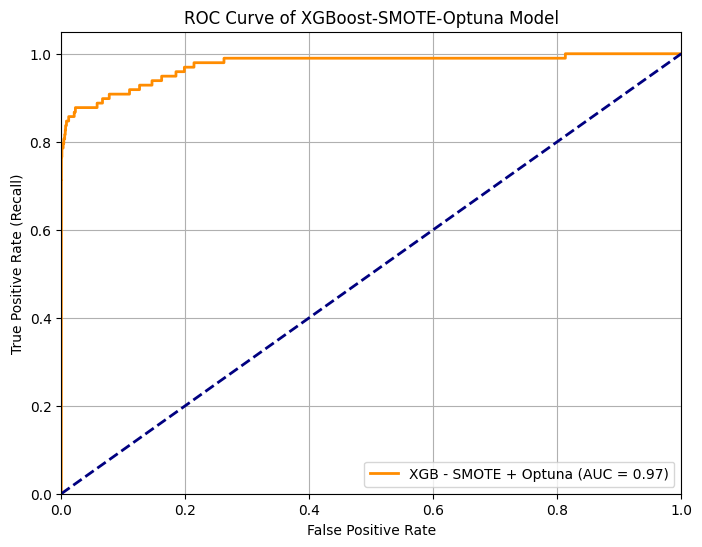

In [ ]:
# Predict probabilities for Class 1 (Fraud)
y_proba = xgb_smote_optuna_model.predict_proba(X_test)[:, 1]

# Compute ROC Curve and ROC Area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"XGB - SMOTE + Optuna (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve of XGBoost-SMOTE-Optuna Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**ROC-AUC Score Interpretation**

- 0.9-1.0 --> Excellent or outstanding

- 0.8-0.9 --> Very good

- 0.7-0.8 --> Good

- 0.6-0.7 --> Fair

- 0.5-0.6 --> Poor

- 0.5 --> No better than random

- < 0.5 --> Worse than random

The ROC Curve shows how the model performs across different thresholds. The closer the curve is to the top-left corner, the better the model is at distinguishing between fraud and non-fraud cases.

With an AUC score of 0.97 which falls under excellent/outstanding criteria, the XGBoost-SMOTE-Optuna model demonstrates excellent discrimination ability, meaning it is very effective in separating fraud cases from legitimate ones.

## X. SAVING THE CHOSEN MODEL FOR FUTURE TEST & USE

In [ ]:
# Save chosen XGB-SMOTE-Optuna model
joblib.dump(xgb_smote_optuna_model, 'xgb_smote_optuna_model.pkl')
print("Model successfully saved as 'xgb_smote_optuna_model.pkl'")

Model successfully saved as 'xgb_smote_optuna_model.pkl'


**Alright, now let's give it a try by applying the chosen & saved model into random dataset.**

In [ ]:
# Load the saved model
xgb_smote_optuna_model = joblib.load('xgb_smote_optuna_model.pkl')

In [ ]:
# Get the number of features based on the original TEST set
num_features = X_test.shape[1] # make sure X_test is from your trained data

# Generate 5 random transactions for testing
random_data = np.random.rand(5, num_features)

# Convert to DataFrame using same column names as X_test
df_random_test = pd.DataFrame(random_data, columns=X_test.columns)

# Display the generated random transactions
print(df_random_test.head())

         V1        V2        V3        V4        V5        V6        V7  \
0  0.091569  0.924140  0.995441  0.490375  0.148973  0.962467  0.105650   
1  0.663141  0.240896  0.948645  0.415131  0.786176  0.130215  0.985562   
2  0.577320  0.493835  0.964241  0.689580  0.370354  0.172287  0.241513   
3  0.257689  0.251807  0.000859  0.891693  0.113063  0.671349  0.969041   
4  0.712382  0.519758  0.691397  0.654779  0.533318  0.725905  0.943609   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.406302  0.454746  0.044518  ...  0.825888  0.694687  0.367808  0.015571   
1  0.396703  0.164078  0.854516  ...  0.532999  0.472384  0.618552  0.127836   
2  0.793963  0.426358  0.515704  ...  0.596689  0.220687  0.067259  0.852467   
3  0.477561  0.767249  0.518589  ...  0.471600  0.254924  0.556744  0.370452   
4  0.637394  0.647223  0.947578  ...  0.302925  0.775082  0.076108  0.604837   

        V25       V26       V27       V28  Amount_scaled  Time_scale

In [ ]:
# Predict class (0=normal, 1=fraud)
predicted_class = xgb_smote_optuna_model.predict(df_random_test)

# Predict probability of Fraud (class 1)
predicted_proba = xgb_smote_optuna_model.predict_proba(df_random_test)[:, 1]

# Combine results with the original random test data
df_random_test['Predicted_Class'] = predicted_class
df_random_test['Fraud_Probability'] = predicted_proba

# Display all probabilities in float format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Show final result with prediction and probability
print(df_random_test)

        V1       V2       V3       V4       V5       V6       V7       V8  \
0 0.091569 0.924140 0.995441 0.490375 0.148973 0.962467 0.105650 0.406302   
1 0.663141 0.240896 0.948645 0.415131 0.786176 0.130215 0.985562 0.396703   
2 0.577320 0.493835 0.964241 0.689580 0.370354 0.172287 0.241513 0.793963   
3 0.257689 0.251807 0.000859 0.891693 0.113063 0.671349 0.969041 0.477561   
4 0.712382 0.519758 0.691397 0.654779 0.533318 0.725905 0.943609 0.637394   

        V9      V10  ...      V23      V24      V25      V26      V27  \
0 0.454746 0.044518  ... 0.367808 0.015571 0.723573 0.845879 0.046912   
1 0.164078 0.854516  ... 0.618552 0.127836 0.993734 0.865737 0.423941   
2 0.426358 0.515704  ... 0.067259 0.852467 0.163199 0.020449 0.589930   
3 0.767249 0.518589  ... 0.556744 0.370452 0.809858 0.537512 0.635303   
4 0.647223 0.947578  ... 0.076108 0.604837 0.871142 0.371126 0.548462   

       V28  Amount_scaled  Time_scaled  Predicted_Class  Fraud_Probability  
0 0.366916       0.24

In [ ]:
# Show each prediction with formatted text
for i, row in df_random_test.iterrows():
    label = "FRAUD" if row['Predicted_Class'] == 1 else "LEGITIMATE"
    prob = row['Fraud_Probability']
    print(f"Transaction {i+1}: Predicted as {label} with fraud probability of {prob:.6f}")

Transaction 1: Predicted as LEGITIMATE with fraud probability of 0.000147
Transaction 2: Predicted as LEGITIMATE with fraud probability of 0.000432
Transaction 3: Predicted as LEGITIMATE with fraud probability of 0.000169
Transaction 4: Predicted as LEGITIMATE with fraud probability of 0.000410
Transaction 5: Predicted as LEGITIMATE with fraud probability of 0.000330


## XI. KEY STEPS TAKEN

**1. Data Loading and Exploration**
- Loaded the dataset containing credit card transactions.
- Explored class imbalance between Fraud (1) and Non-fraud (0).
- Checked for missing values and basic statistics.

**2. Data Preprocessing**
- Scaled the Amount and Time columns using StandardScaler.
- Dropped the original unscaled Amount and Time columns.
- Separated features and target variable.

**3. Data Splitting**
- Split the data into Training and Testing sets (stratified by Class) to maintain Fraud Cases distribution.

**4. Handling Class Imbalance**
- Applied SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class (Fraud) in the Training dataset.
- Used Optuna for Hyperparameter Tuning to optimize model performance.

**5. Model Training**
- Trained multiple models and selected **XGBoost with SMOTE and Optuna tuning (4th model)** as the final choice due to its strong and balanced fraud detection performance.

**6. Model Evaluation**
- Evaluated the trained models using Confusion Matrix, Classification Report, and ROC-AUC curve.
- Analyzed the Recall, Precision, and F1-score specifically for fraud detection.

**7. Model Saving, Testing, and Inference**
- Saved the best-performing model **(xgb_smote_optuna_model)** using joblib.
- Generated synthetic test transactions for model testing **(random data)**.
- Predicted fraud probability and class for each synthetic transaction.

## XII. EXECUTIVE SUMMARY

This project aims to detect fraudulent credit card transactions using machine learning. The data shows a heavy class imbalance, with fraud cases making up less than 0.2% of all transactions.

After preprocessing, applying SMOTE to balance the data, and applying Optuna for Hyperparameter Tuning, the XGBoost model was trained and selected for its superior yet balanced performance.

The final model showed strong Recall and Precision Scores, which are essential for minimizing False Negatives **(missing actual fraud cases)** whle also **reducing false alarms** (False Positives). The model was saved and successfully tested on simulated data, providing fraud probability scores for new randomly created transactions.

This workflow demonstrates a scalable approach to building an effective fraud detection system.